In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import functools

# This function was copy-pasted by YoshiRi/HDRpython
#   * https://github.com/YoshiRi/HDRpython
#   * https://ossyaritoori.hatenablog.com/entry/2017/09/17/OpenCV_Python_%E3%81%A7HDR%E7%94%BB%E5%83%8F%E3%82%92%E5%90%88%E6%88%90%E3%81%97%E3%81%A6%E3%81%BF%E3%82%88%E3%81%86#%EF%BC%91%E6%89%8B%E3%81%B6%E3%82%8C%E8%A3%9C%E6%AD%A3
#http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html
#Akaze is better? http://poly.hatenablog.com/entry/2014/01/06/063012
def getMatchedPoints(img1,img2):
    # ORB (Oriented FAST and Rotated BRIEF)
    #detector = cv2.ORB_create(nfeatures=500,scoreType=cv2.ORB_HARRIS_SCORE)
    detector = cv2.AKAZE_create()
    #detector = cv2.KAZE_create()


    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    kp1,des1 = detector.detectAndCompute(imagePreProcessForMatching(img1),None)
    kp2,des2 = detector.detectAndCompute(imagePreProcessForMatching(img2),None)

    # Match descriptors.
    #https://stackoverflow.com/questions/31690265/matching-features-with-orb-python-opencv
    matches = bf.knnMatch(des1,des2,k=2)

    good = []
    pts1 = []
    pts2 = []
   
    count = 0
    for m,n in matches:      
        if m.distance < 0.5*n.distance:
            good.append([m])
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt) 
            count+=1
    print(count)
    # https://stackoverflow.com/questions/31631352/typeerror-required-argument-outimg-pos-6-not-found
    #img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:count],None, flags=2)
    #cv2.imshow("matching",img3)
    #cv2.waitKey(0)
   
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    return pts1,pts2

def imagePreProcessForMatching(img):

    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    a = 64
    b = 10
    img_gray = img_yuv[:,:,0].astype(np.float)
    kernel = np.ones((5,5),np.float32)/25
    #img_gray = cv2.filter2D(img_gray,-1,kernel)
    #img_gray2 = cv2.equalizeHist((img_gray-50).clip(0, 255).astype(np.uint8))

    #img_gray = img[:,:,0].astype(np.float)
    img_gray2 = ((img_gray / np.mean(img_gray[img_gray > 30])) * 128 ).clip(0, 255).astype(np.uint8)
    #img_gray = ((img_gray.astype(np.int32) - np.median(img_gray))/np.std(img_gray)*a + b ).clip(0, 255).astype(np.uint8)
    #img_gray2 = ((img_gray - np.mean(img_gray[img_gray < 200]))/np.std(img_gray[img_gray < 200])*a + b).clip(0, 255).astype(np.uint8)
    #img_gray2 = ((img_gray - np.median(img_gray)) + 128).clip(0, 255).astype(np.uint8)
    #img_gray2 = cv2.equalizeHist(img_gray)
    #return img_gray2
    img_yuv[:,:,0] = img_gray2
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img
    

def imageDeformation(img_base,img_sub):
    [pts1, pts2] = getMatchedPoints(img_sub,img_base)
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    Imsize=(img_base.shape[1],img_base.shape[0])
    im_dst = cv2.warpPerspective(img_sub, H, Imsize)
    return im_dst

def imageAverage(img_base,img_list):
    total = len(img_list) + 1
    img_list2 = [imageDeformation(img_base,im) for im in img_list]
    for i, img in enumerate([img_base] + img_list2):
        cv2.imwrite("intermediate/deformation"+str(i)+".jpg", img)
    img_sum = (functools.reduce(lambda sum, item: sum + item.astype(np.float32), img_list2, img_base.astype(np.float32)))

    gamma = 1.0 / 2.0

    return (((img_sum/total)/255.0).clip(0, 1) ** gamma * 260.0 - 10.0).clip(0, 255).astype(np.uint8)

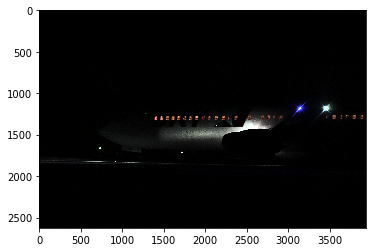

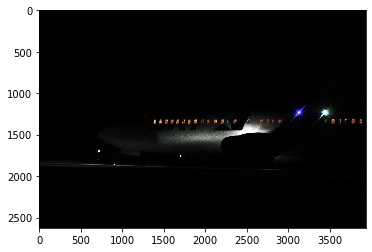

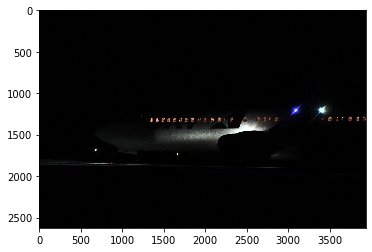

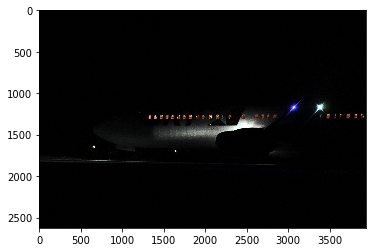

In [2]:
import glob
for i,img in enumerate([cv2.imread(fn) for fn in glob.glob("./in/*")]):
    img = imagePreProcessForMatching(img)
    plt.imshow(img),plt.show()
    cv2.imwrite("intermediate/matching"+str(i)+".jpg", img)

In [3]:
def imgPreProcess(img):
    return img

import glob
glob.glob("./in/*")

img_readed = [cv2.imread(fn) for fn in glob.glob("./in/*")]
img_list = [imgPreProcess(img) for img in img_readed]
img_base = img_list[0]
img_subs = img_list[1:]

img_avg = imageAverage(img_base,img_subs)
cv2.imwrite("out1.png", img_avg)



182
177
186


True